In [136]:
import pickle
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from modt.modt import MoDT
from modt._initialization import *
from modt.visualization import *
from modt.utility import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 12

COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR

Max depth: 1
Accuracy disjoint DTs: 0.96
Min:  0.84 Max:  0.96


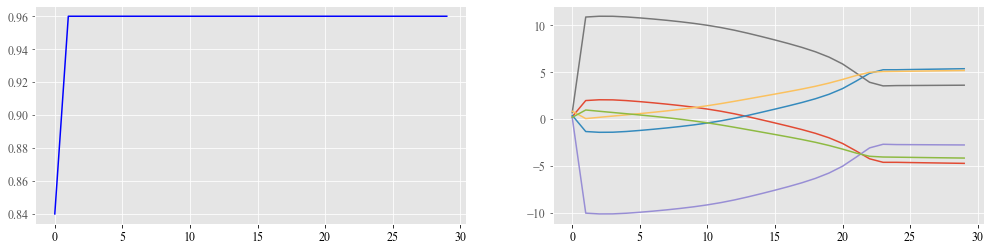

In [137]:
data_input = pickle.load(open("../datasets/iris_input.pd", "rb"))
data_target = pickle.load(open("../datasets/iris_target.pd", "rb"))

parameters = {
    "X": data_input,
    "y": data_target,
    "n_experts": 2,
    "iterations": 30,
    "max_depth": 1,
    "init_learning_rate": 80,
    "learning_rate_decay": 0.995,
    "initialization_method": "random",
    "feature_names": None,
    "class_names": None,
    "use_2_dim_gate_based_on": "feature_importance_lda_max",
    "use_2_dim_clustering": False,
    "black_box_algorithm": None,
    "save_likelihood": True,
    }

parameters_fit = {
    "optimization_method": "ridge_regression",
    "early_stopping": False,
    "use_posterior": False,
    }

modt = MoDT(**parameters)
modt.fit(**parameters_fit)
print("Max depth:",modt.max_depth)
print("Accuracy disjoint DTs:", modt.score_internal_disjoint())
fig = plt.gcf()
fig.set_size_inches(17, 4)
plt.subplot(1, 2, 1)
accuracy_line(modt)
plt.subplot(1, 2, 2)
theta_development(modt)

In [159]:
color_schema = [
    "#E24A33",
    "#8EBA42",    
    "#81D0DB",
    "#FBC15E",
    "#B97357",
    #"#348ABD",
    "#988ED5",
]   
scatter_color_schema = {
    0 : "#46befa", # blue
    1 : "#f64931", # red
    2 : "#b8ff3b", # green
}

In [176]:
def rand_jitter(arr):
    stdev = .005 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def visualize_new(modt,
                     iteration,
                     ax=None,
                     cmap='rainbow',
                     enable_scatter=True,
                     low_alpha=False,
                     title=True, 
                     axis_digits=False,
                     axis_ticks=True,
                     jitter=False,
                     inverse_transform_standardization=False):
    
    plt.figure(figsize=(3,2))
    ax = plt.gca()
    y = modt.y

    if modt.use_2_dim_gate_based_on is not None:
        X = modt.X_2_dim
    else:
        X = modt.X_original
        if X.shape[1] != 2:
            raise ValueError("X must have 2 dimensions for visualization.")
            
    point_size=10
    
#    if jitter:
#        ax.scatter(rand_jitter(X[:, 0]), rand_jitter(X[:, 1]), c=y, s=point_size, 
#                        clim=(y.min(), y.max()), zorder=3)
#    else:
#        ax.scatter(X[:, 0], X[:, 1], c=y, s=point_size, clim=(y.min(), y.max()), zorder=3)        
        
    if jitter:
        ax.scatter(rand_jitter(X[:, 0]), rand_jitter(X[:, 1]),
                   c=list(map(lambda x: scatter_color_schema[x], modt.y)),
                   s=point_size, clim=(y.min(), y.max()), zorder=3)
    else:
        ax.scatter(X[:, 0], X[:, 1], c=list(map(lambda x: scatter_color_schema[x], modt.y)),
                   s=point_size, clim=(y.min(), y.max()), zorder=3)         
        
    if False and inverse_transform_standardization:
        X_reverse = modt.scaler.inverse_transform(modt.X[:,:-1])  # Also removes last column (bias)
        mask = modt.X_top_2_mask[:-1]
        ax.scatter(X_reverse[:, mask[0]], X_reverse[:, mask[1]], c="red", alpha=1.0, s=point_size, clim=(y.min(), y.max()), zorder=3)
        
    ax.axis('tight')
    if not axis_ticks:
        ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim() 
    
    names_selected_features = modt.feature_names[modt.X_top_2_mask[:-1]]
    ax.set_xlabel(names_selected_features[0], fontsize=12)        
    ax.set_ylabel(names_selected_features[1], fontsize=12)

    # Overwrite axis ticks by reversing the standardization of the original ticks
    if inverse_transform_standardization: 
        mask = modt.X_top_2_mask[:-1]
        placeholder = np.zeros((len(ax.get_xticks()),modt.X.shape[1]-1))
        placeholder[:,mask[0]] = ax.get_xticks()
        new_x_ticks = modt.scaler.inverse_transform(placeholder)[:,mask[0]]
        new_x_ticks = np.around(new_x_ticks,1)
        ax.set_xticklabels(new_x_ticks)
        
        placeholder = np.zeros((len(ax.get_yticks()),modt.X.shape[1]-1))
        placeholder[:,mask[1]] = ax.get_yticks()
        new_y_ticks = modt.scaler.inverse_transform(placeholder)[:,mask[1]]
        new_y_ticks = np.around(new_y_ticks,1)
        ax.set_yticklabels(new_y_ticks) 
        
    if not axis_digits:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))

    grid = np.c_[xx.ravel(), yy.ravel()]

    if modt.use_2_dim_gate_based_on is not None:
        grid = np.append(grid, np.ones([grid.shape[0], 1]),axis=1) # Bias
        Z = modt.get_expert(grid, iteration, internal=True).reshape(xx.shape)
    else:
        Z = modt.get_expert(grid, iteration, internal=False).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(Z))
    contours = ax.contourf(xx, yy, Z, alpha=0.6,
                           levels=np.arange(n_classes + 1) - 0.5,
                           colors=color_schema,
                           zorder=1)
    
    if title:
        plt.title("iteration: {}".format(iteration))
        
    plt.savefig("output/gate.pdf", bbox_inches="tight")

<ipython-input-176-b98d1aed6ae4>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_x_ticks)
<ipython-input-176-b98d1aed6ae4>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_y_ticks)


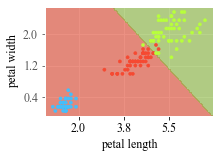

In [177]:
visualize_new(modt,iteration=modt.completed_iterations, title=False, axis_digits=True, inverse_transform_standardization=True)

In [143]:
pickle_disjoint_data(modt, iteration=modt.completed_iterations)

In [144]:
df1 = pd.read_pickle("output/disjoint_data_e_0.pd")

In [145]:
df1["target"].value_counts()

Iris-setosa        50
Iris-versicolor    47
Iris-virginica      1
Name: target, dtype: int64

In [146]:
df2 = pd.read_pickle("output/disjoint_data_e_1.pd")
df2["target"].value_counts()

Iris-virginica     49
Iris-versicolor     3
Name: target, dtype: int64

In [147]:
df2

,sepal length,sepal width,petal length,petal width,target
70,5.9,3.2,4.8,1.8,Iris-versicolor
77,6.7,3.0,5.0,1.7,Iris-versicolor
83,6.0,2.7,5.1,1.6,Iris-versicolor
100,6.3,3.3,6.0,2.5,Iris-virginica
101,5.8,2.7,5.1,1.9,Iris-virginica
102,7.1,3.0,5.9,2.1,Iris-virginica
103,6.3,2.9,5.6,1.8,Iris-virginica
104,6.5,3.0,5.8,2.2,Iris-virginica
105,7.6,3.0,6.6,2.1,Iris-virginica
107,7.3,2.9,6.3,1.8,Iris-virginica
